# Optimization of a Dissipative Quantum Gate

$
\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{ketbra}[2]{\vert#1\rangle\langle#2\vert}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
$

This example illustrates the optimization for a quantum gate in an open
quantum system, where the dynamics is governed by the Liouville-von Neumann
equation.

In [1]:
datadir(names...) = joinpath(@__DIR__, names...);

using QuantumControl
using LinearAlgebra
using Serialization
using SparseArrays

In [2]:
using Plots
Plots.default(
    linewidth               = 3,
    size                    = (550, 300),
    legend                  = :right,
    foreground_color_legend = nothing,
    background_color_legend = RGBA(1, 1, 1, 0.8),
)

## The two-transmon system

We will use internal units GHz and ns. Values in GHz contain an implicit
factor $2 \pi$, and MHz and μs are converted to GHz and ns, respectively:

In [3]:
const GHz = 2π;
const MHz = 0.001GHz;
const ns = 1.0;
const μs = 1000ns;
const 𝕚 = 1im;

This implicit factor $2 \pi$ is because frequencies ($\nu$) convert to
energies as $E = h \nu$, but our propagation routines assume a unit $\hbar =
1$ for energies. Thus, the factor $h / \hbar = 2 \pi$.

In [4]:
function transmon_liouvillian(
    Ωre,
    Ωim;
    N=5,             # number of qubit levels
    ω₁=4.3796GHz,    # qubit frequency 1
    ω₂=4.6137GHz,    # qubit frequency 2
    ωd=4.4985GHz,    # drive frequency
    δ₁=-239.3MHz,    # anharmonicity 1
    δ₂=-242.8MHz,    # anharmonicity 2
    J=-2.3MHz,       # effective qubit-qubit coupling
    γ₁₁=(1 / 38.0μs),  # decay rate for qubit 1
    γ₁₂=(1 / 32.0μs),  # decay rate for qubit 2
    γ₂₁=(1 / 29.5μs),  # dephasing rate for qubit 1
    γ₂₂=(1 / 16.0μs)  # dephasing time for qubit 2
)

    ⊗(A, B) = kron(A, B)
    𝟙 = SparseMatrixCSC{ComplexF64,Int64}(sparse(I, N, N))

    b̂₁ = spdiagm(1 => complex.(sqrt.(collect(1:N-1)))) ⊗ 𝟙
    b̂₂ = 𝟙 ⊗ spdiagm(1 => complex.(sqrt.(collect(1:N-1))))
    b̂₁⁺ = sparse(b̂₁')
    b̂₂⁺ = sparse(b̂₂')
    n̂₁ = sparse(b̂₁' * b̂₁)
    n̂₂ = sparse(b̂₂' * b̂₂)
    n̂₁² = sparse(n̂₁ * n̂₁)
    n̂₂² = sparse(n̂₂ * n̂₂)
    b̂₁⁺_b̂₂ = sparse(b̂₁' * b̂₂)
    b̂₁_b̂₂⁺ = sparse(b̂₁ * b̂₂')

    Ĥ₀ = sparse(
        (ω₁ - ωd - δ₁ / 2) * n̂₁ +
        (δ₁ / 2) * n̂₁² +
        (ω₂ - ωd - δ₂ / 2) * n̂₂ +
        (δ₂ / 2) * n̂₂² +
        J * (b̂₁⁺_b̂₂ + b̂₁_b̂₂⁺)
    )

    Ĥ₁re = (1 / 2) * (b̂₁ + b̂₁⁺ + b̂₂ + b̂₂⁺)
    Ĥ₁im = (𝕚 / 2) * (b̂₁⁺ - b̂₁ + b̂₂⁺ - b̂₂)

    H = (Ĥ₀, (Ĥ₁re, Ωre), (Ĥ₁im, Ωim))

    c_ops = [√γ₁₁ * b̂₁, √γ₁₂ * b̂₂, √γ₂₁ * n̂₁, √γ₂₂ * n̂₂]

    return liouvillian(H, c_ops; convention=:TDSE)

end

const T = 400ns;

Ωre(t) = 35MHz * QuantumControl.Shapes.flattop(t; T=T, t_rise=20ns);
Ωim(t) = 0.0;

L = transmon_liouvillian(Ωre, Ωim);

tlist = collect(range(0, 400ns, length=2000));

The guess pulse looks as follows:

In [5]:
function plot_control(pulse::Vector, tlist)
    plot(tlist, pulse, xlabel="time", ylabel="amplitude", legend=false)
end

plot_control(ϵ::Function, tlist) = plot_control([ϵ(t) for t in tlist], tlist);

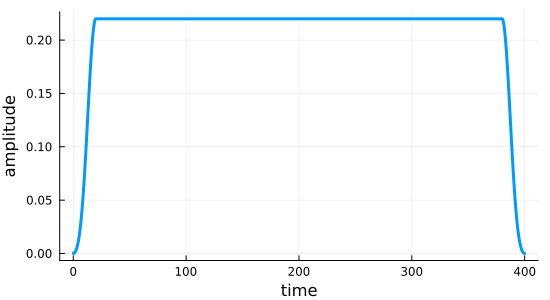

In [6]:
fig = plot_control(Ωre, tlist)

## Three-State Trajectories for Open System Gate Optimization

Our target gate is $\op{O} = \sqrt{\text{iSWAP}}$:

In [7]:
SQRTISWAP = [
    1  0    0   0
    0 1/√2 𝕚/√2 0
    0 𝕚/√2 1/√2 0
    0  0    0   1
];

The key idea explored in the paper is that a set of three density matrices is sufficient to track the optimization

$$
\begin{align}
\op{\rho}_1
    &= \sum_{i=1}^{d} \frac{2 (d-i+1)}{d (d+1)} \ketbra{i}{i} \\
\op{\rho}_2
    &= \sum_{i,j=1}^{d} \frac{1}{d} \ketbra{i}{j} \\
\op{\rho}_3
    &= \sum_{i=1}^{d} \frac{1}{d} \ketbra{i}{i}
\end{align}
$$

In our case, $d=4$ for a two qubit-gate, and the $\ket{i}$, $\ket{j}$ are the canonical basis states $\ket{00}$, $\ket{01}$, $\ket{10}$, $\ket{11}$

In [8]:
function ket(i::Int64; N=5)
    Ψ = zeros(ComplexF64, N)
    Ψ[i+1] = 1
    return Ψ
end;

ket(i::Int64, j::Int64; N=5) = kron(ket(i; N=N), ket(j; N=N));

bra(args...; N=5) = adjoint(ket(args..., N=N));

const basis_labels = [(0, 0), (0, 1), (1, 0), (1, 1)];
const basis = [ket(labels...) for labels in basis_labels];
const d = length(basis);

const basis_tgt = [sum([SQRTISWAP[i, j] * basis[i] for i ∈ 1:d]) for j ∈ 1:d];


const ρ̂₁ =
    sum([(2 * (d - i + 1) / (d * (d + 1))) * basis[i] * adjoint(basis[i]) for i ∈ 1:d]);
const ρ̂₂ = sum([(1 / d) * basis[i] * adjoint(basis[j]) for i ∈ 1:d for j ∈ 1:d]);
const ρ̂₃ = sum([(1 / d) * basis[i] * adjoint(basis[i]) for i ∈ 1:d]);

const ρ̂₁_tgt = sum([
    (2 * (d - i + 1) / (d * (d + 1))) * basis_tgt[i] * adjoint(basis_tgt[i]) for i ∈ 1:d
]);
const ρ̂₂_tgt =
    sum([(1 / d) * basis_tgt[i] * adjoint(basis_tgt[j]) for i ∈ 1:d for j ∈ 1:d]);
const ρ̂₃_tgt = sum([(1 / d) * basis_tgt[i] * adjoint(basis_tgt[i]) for i ∈ 1:d]);

The three density matrices play different roles in the optimization, and, as
shown in the paper, convergence may improve significantly by weighing the
states relatively to each other. For this example, we place a strong emphasis
on the optimization $\op{\rho}_1 \rightarrow \op{O}^\dagger \op{\rho}_1
\op{O}$, by a factor of 20. This reflects that the hardest part of the
optimization is identifying the basis in which the gate is diagonal. We will
be using the real-part functional ($J_{T,\text{re}}$) to evaluate the success
of $\op{\rho}_i \rightarrow \op{O}\op{\rho}_i\op{O}^\dagger$. Because
$\op{\rho}_1$ and $\op{\rho}_3$ are mixed states, the Hilbert-Schmidt overlap
will take values smaller than one in the optimal case. To compensate, we
divide the weights by the purity of the respective states.

In [9]:
weights = Float64[20, 1, 1];
weights *= length(weights) / sum(weights); # manual normalization
weights ./= [0.3, 1.0, 0.25]; # purities

const trajectories = [
    Trajectory(
        initial_state=reshape(ρ̂₁, :),
        generator=L,
        target_state=reshape(ρ̂₁_tgt, :),
        weight=weights[1]
    ),
    Trajectory(
        initial_state=reshape(ρ̂₂, :),
        generator=L,
        target_state=reshape(ρ̂₂_tgt, :),
        weight=weights[2]
    ),
    Trajectory(
        initial_state=reshape(ρ̂₃, :),
        generator=L,
        target_state=reshape(ρ̂₃_tgt, :),
        weight=weights[3]
    )
]

3-element Vector{QuantumControlBase.Trajectory{Vector{ComplexF64}, QuantumPropagators.Generators.Generator{SparseArrays.SparseMatrixCSC{ComplexF64, Int64}, Function}}}:
 Trajectory with 625-element Vector{ComplexF64} initial state, Generator with 3 ops and 2 amplitudes, 625-element Vector{ComplexF64} target state, weight=9.09090909090909
 Trajectory with 625-element Vector{ComplexF64} initial state, Generator with 3 ops and 2 amplitudes, 625-element Vector{ComplexF64} target state, weight=0.13636363636363635
 Trajectory with 625-element Vector{ComplexF64} initial state, Generator with 3 ops and 2 amplitudes, 625-element Vector{ComplexF64} target state, weight=0.5454545454545454

## Dynamics under the Guess Pulse

In [10]:
ρ̂₀₀ = ket(0, 0) * adjoint(ket(0, 0));
ρ̂₀₁ = ket(0, 1) * adjoint(ket(0, 1));
ρ̂₁₀ = ket(1, 0) * adjoint(ket(1, 0));
ρ̂₁₁ = ket(1, 1) * adjoint(ket(1, 1));

function as_matrix(ρ⃗)
    N = isqrt(length(ρ⃗))
    return reshape(ρ⃗, N, N)
end;

pop00(ρ⃗) = real(tr(as_matrix(ρ⃗) * ρ̂₀₀));
pop01(ρ⃗) = real(tr(as_matrix(ρ⃗) * ρ̂₀₁));
pop10(ρ⃗) = real(tr(as_matrix(ρ⃗) * ρ̂₁₀));
pop11(ρ⃗) = real(tr(as_matrix(ρ⃗) * ρ̂₁₁));


using QuantumPropagators: Newton

rho_00_expvals = propagate_trajectory(
    trajectories[1],
    tlist;
    initial_state=reshape(ρ̂₀₀, :),
    method=Newton,
    observables=(pop00, pop01, pop10, pop11),
    storage=true
);

## Optimization

In [11]:
problem = ControlProblem(
    trajectories,
    tlist;
    prop_method=Newton,
    use_threads=true,
    lambda_a=1.0,
    update_shape=(t -> QuantumControl.Shapes.flattop(t, T=T, t_rise=20ns, func=:blackman)),
    iter_stop=3000,
    J_T=QuantumControl.Functionals.J_T_re,
    check_convergence=res -> begin
        ((res.J_T < 1e-3) && (res.converged = true) && (res.message = "J_T < 10⁻³"))
    end
);

In [12]:
using Krotov
opt_result = @optimize_or_load(
    datadir("DissGateOCT#J_T=J_T_re#iter_stop=3000#method=krotov.jld2"),
    problem,
    method = Krotov,
)
nothing #hide

 iter.        J_T   ∫gₐ(t)dt          J       ΔJ_T         ΔJ    secs
     0   1.06e-01   0.00e+00   1.06e-01        n/a        n/a     3.3
[ Info: Set callback to store result in DissGateOCT#J_T=J_T_re#iter_stop=3000#method=krotov.jld2 on unexpected exit.
     1   7.44e-02   1.58e-02   9.01e-02  -3.15e-02  -1.57e-02     6.1
     2   7.37e-02   3.52e-04   7.40e-02  -7.03e-04  -3.52e-04     4.4
     3   7.30e-02   3.33e-04   7.33e-02  -6.65e-04  -3.32e-04     4.2
     4   7.24e-02   3.15e-04   7.27e-02  -6.29e-04  -3.14e-04     4.3
     5   7.18e-02   2.99e-04   7.21e-02  -5.97e-04  -2.98e-04     4.6
     6   7.12e-02   2.84e-04   7.15e-02  -5.68e-04  -2.84e-04     4.7
     7   7.07e-02   2.71e-04   7.09e-02  -5.41e-04  -2.71e-04     4.4
     8   7.02e-02   2.59e-04   7.04e-02  -5.17e-04  -2.58e-04     4.1
     9   6.97e-02   2.48e-04   6.99e-02  -4.95e-04  -2.48e-04     4.7
    10   6.92e-02   2.38e-04   6.94e-02  -4.76e-04  -2.38e-04     4.7
    11   6.87e-02   2.29e-04   6.90e-02  -4

In [13]:
opt_result #hide

Krotov Optimization Result
--------------------------
- Started at 2024-05-19T23:10:38.172
- Number of trajectories: 3
- Number of iterations: 3000
- Value of functional: 2.84800e-03
- Reason for termination: Reached maximum number of iterations
- Ended at 2024-05-20T02:24:41.966 (3 hours, 14 minutes, 3 seconds, 794 milliseconds)
